In [47]:
# Data & Viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model building
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from pyproj import Transformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Explainability
import shap
shap.initjs()

# Optional: Clean up warning messages
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries loaded successfully!")


✅ All libraries loaded successfully!


In [48]:
# Safer loading with fallback encoding
caract = pd.read_csv("caract-2023.csv", sep=";", encoding="utf-8")
lieux = pd.read_csv("lieux-2023.csv", sep=";", encoding="utf-8")
usagers = pd.read_csv("usagers-2023.csv", sep=";", encoding="utf-8")
vehic = pd.read_csv('vehicules-2023.csv', sep=';', encoding='utf-8')


print("✅ Files loaded:")
print(f"caract: {caract.shape}")
print(f"lieux: {lieux.shape}")
print(f"usagers: {usagers.shape}")
print(f"vehic: {vehic.shape}")
print(usagers.columns)
print(vehic.columns)
print(caract.columns)
print(lieux.columns)

# Fusion initiale
# 1. Fusionner caract et lieux sur Num_Acc
df_merged = pd.merge(caract, lieux, on='Num_Acc', how='left')

# 2. Fusionner avec usagers sur Num_Acc.
#    Chaque ligne représentera un usager impliqué dans un accident.
#    C'est le plus important car 'grav' est notre cible.
df_merged = pd.merge(df_merged, usagers, on='Num_Acc', how='left')

# 3. Fusionner avec vehicules. Un accident peut avoir plusieurs véhicules,
#    et chaque véhicule peut avoir plusieurs usagers.
#    Pour éviter les doublons excessifs, on fusionne sur Num_Acc et num_veh (ou id_vehicule).
#    Le couple (Num_Acc, num_veh) est unique pour un véhicule dans un accident.
df_merged = pd.merge(df_merged, vehic, on=['Num_Acc', 'num_veh'], how='left')

print(f"Dimension du DataFrame fusionné : {df_merged.shape}")
print(df_merged.head())





✅ Files loaded:
caract: (54822, 15)
lieux: (70860, 18)
usagers: (125789, 16)
vehic: (93585, 11)
Index(['Num_Acc', 'id_usager', 'id_vehicule', 'num_veh', 'place', 'catu',
       'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'locp',
       'actp', 'etatp'],
      dtype='object')
Index(['Num_Acc', 'id_vehicule', 'num_veh', 'senc', 'catv', 'obs', 'obsm',
       'choc', 'manv', 'motor', 'occutc'],
      dtype='object')
Index(['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg',
       'int', 'atm', 'col', 'adr', 'lat', 'long'],
      dtype='object')
Index(['Num_Acc', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof',
       'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ',
       'vma'],
      dtype='object')
Dimension du DataFrame fusionné : (163683, 56)
        Num_Acc  jour  mois    an   hrmn  lum dep    com  agg  int  ...  \
0  202300000001     7     5  2023  06:00    1  75  75101    2    4  ...   
1  202300000001     7     5  2

In [32]:
# 1. Dimension & Qualité des Données
print(f"Nombre de lignes : {df_merged.shape[0]}")
print(f"Nombre de colonnes : {df_merged.shape[1]}")

missing_values = df_merged.isnull().sum()
missing_percentage = (missing_values / len(df_merged)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage (%)': missing_percentage})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Percentage (%)', ascending=False)
print("\nValeurs manquantes par colonne :")
print(missing_df)

print("\nTypes de données :")
print(df_merged.dtypes.value_counts())
# Mapper les valeurs de la cible 'grav' pour une meilleure lisibilité
grav_mapping = {1: 'Indemne', 2: 'Blessé léger', 3: 'Blessé hospitalisé', 4: 'Tué'}
df_merged['grav_label'] = df_merged['grav'].map(grav_mapping)

Nombre de lignes : 163683
Nombre de colonnes : 56

Valeurs manquantes par colonne :
         Missing Count  Missing Percentage (%)
lartpc          163605               99.952347
occutc          160957               98.334586
v2              150060               91.677205
voie             28396               17.348167
adr               4051                2.474906
an_nais           3512                2.145611

Types de données :
int64      36
object     18
float64     2
Name: count, dtype: int64


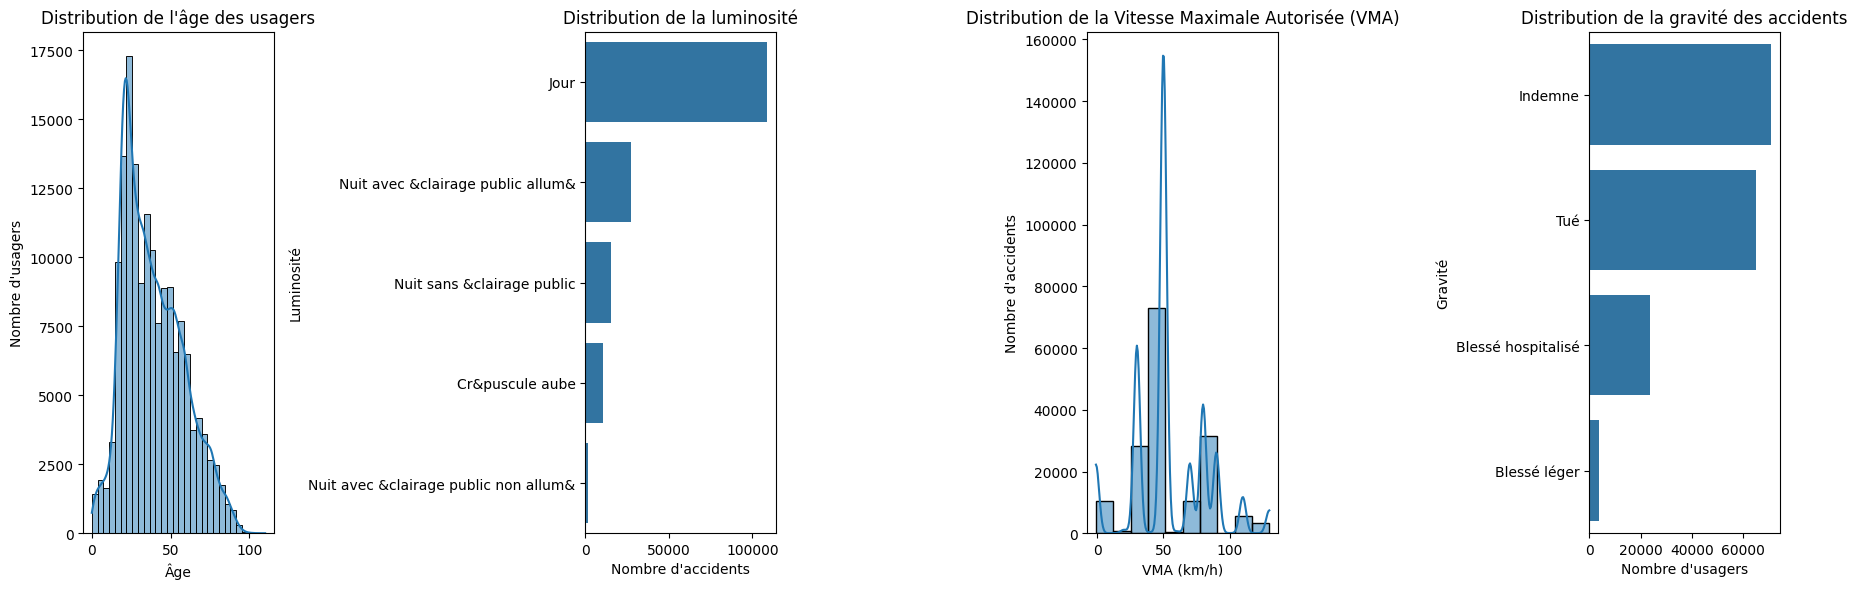


Distribution de la variable cible 'gravité' :
grav_label
Indemne               0.433335
Tué                   0.397041
Blessé hospitalisé    0.145890
Blessé léger          0.023733
Name: proportion, dtype: float64


In [33]:
# 2. Analyse Univariée
plt.figure(figsize=(18, 6))

# Distribution de l'âge (dérivé de an_nais)
# Calculer l'âge à partir de l'année d'accident ('an') et l'année de naissance ('an_nais')
df_merged['age'] = df_merged['an'] - df_merged['an_nais']
plt.subplot(1, 4, 1)
sns.histplot(df_merged['age'].dropna(), bins=30, kde=True) # Utiliser dropna car l'âge peut être manquant
plt.title("Distribution de l'âge des usagers")
plt.xlabel("Âge")
plt.ylabel("Nombre d'usagers")

# Distribution de la luminosité
lum_mapping = {
    1: 'Jour', 2: 'Cr&puscule aube', 3: 'Nuit sans &clairage public',
    4: 'Nuit avec &clairage public non allum&', 5: 'Nuit avec &clairage public allum&'
}
df_merged['lum_label'] = df_merged['lum'].map(lum_mapping)
plt.subplot(1, 4, 2)
sns.countplot(y=df_merged['lum_label'], order=df_merged['lum_label'].value_counts().index)
plt.title("Distribution de la luminosité")
plt.xlabel("Nombre d'accidents")
plt.ylabel("Luminosité")

# Distribution de la vitesse maximale autorisée (vma)
plt.subplot(1, 4, 3)
sns.histplot(df_merged['vma'].dropna(), bins=10, kde=True)
plt.title("Distribution de la Vitesse Maximale Autorisée (VMA)")
plt.xlabel("VMA (km/h)")
plt.ylabel("Nombre d'accidents")

# Distribution de la gravité
plt.subplot(1, 4, 4)
sns.countplot(y=df_merged['grav_label'], order=df_merged['grav_label'].value_counts().index)
plt.title("Distribution de la gravité des accidents")
plt.xlabel("Nombre d'usagers")
plt.ylabel("Gravité")
plt.tight_layout()
plt.show()

print("\nDistribution de la variable cible 'gravité' :")
print(df_merged['grav_label'].value_counts(normalize=True))

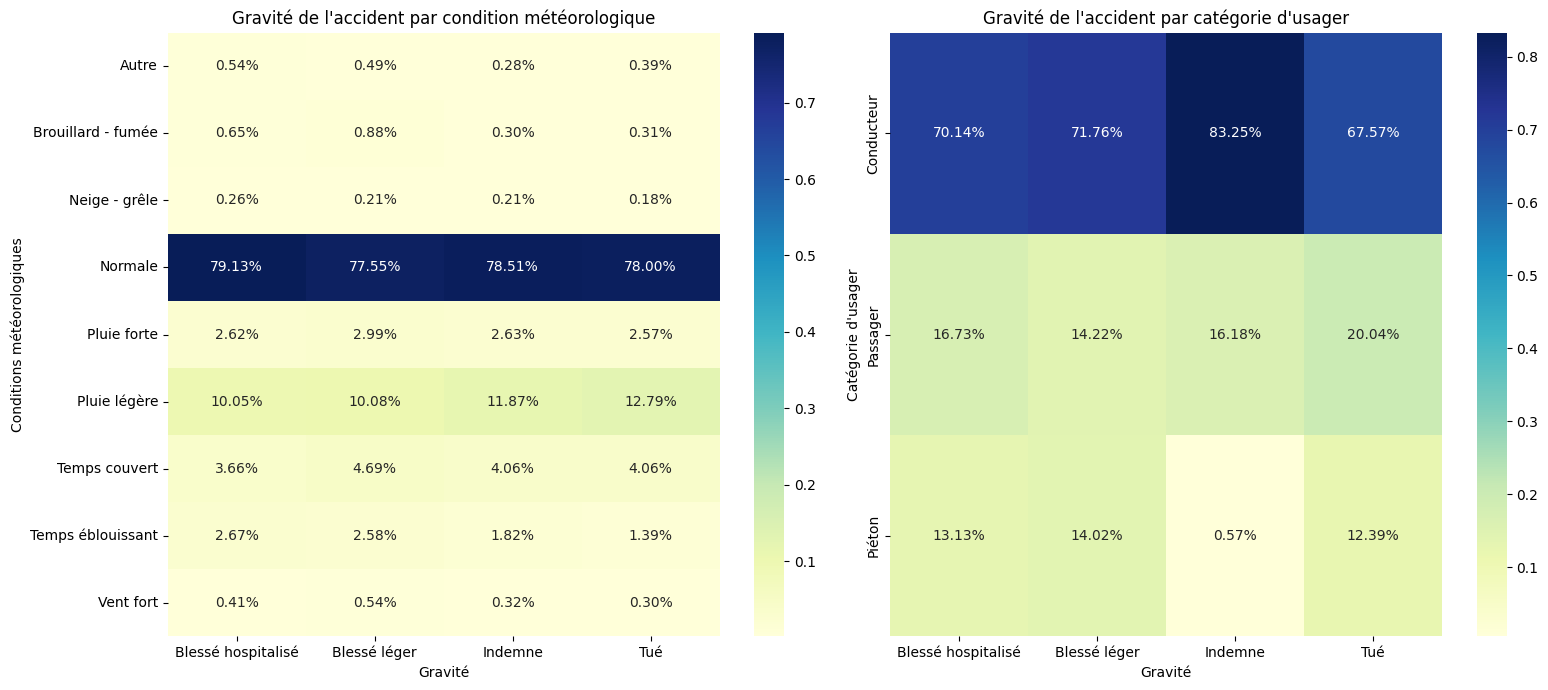

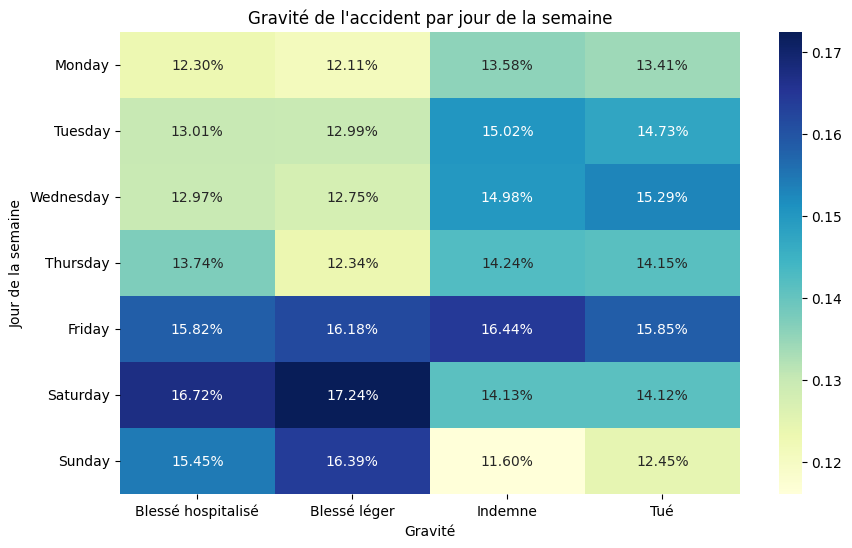

In [34]:
# 3. Analyse Bivariée
# Mappage des codes pour une meilleure lisibilité pour 'atm' et 'catu'
atm_mapping = {
    1: 'Normale', 2: 'Pluie légère', 3: 'Pluie forte', 4: 'Neige - grêle',
    5: 'Brouillard - fumée', 6: 'Vent fort', 7: 'Temps éblouissant', 8: 'Temps couvert',
    9: 'Autre'
}
df_merged['atm_label'] = df_merged['atm'].map(atm_mapping)

catu_mapping = {
    1: 'Conducteur', 2: 'Passager', 3: 'Piéton'
}
df_merged['catu_label'] = df_merged['catu'].map(catu_mapping)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.heatmap(
    pd.crosstab(df_merged['atm_label'], df_merged['grav_label'], normalize='columns'), 
    annot=True, cmap='YlGnBu', fmt=".2%"
)
plt.title("Gravité de l'accident par condition météorologique")
plt.xlabel("Gravité")
plt.ylabel("Conditions météorologiques")

plt.subplot(1, 2, 2)
sns.heatmap(
    pd.crosstab(df_merged['catu_label'], df_merged['grav_label'], normalize='columns'), 
    annot=True, cmap='YlGnBu', fmt=".2%"
)
plt.title("Gravité de l'accident par catégorie d'usager")
plt.xlabel("Gravité")
plt.ylabel("Catégorie d'usager")
plt.tight_layout()
plt.show()

# Dériver le jour de la semaine et l'heure
df_merged['Date'] = pd.to_datetime(dict(year=df_merged['an'], month=df_merged['mois'], day=df_merged['jour']))

def format_hrmn(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and ':' in x:
        return x
    try:
        x_int = int(x)
        return f"{str(x_int).zfill(4)[:2]}:{str(x_int).zfill(4)[2:]}"
    except Exception:
        return np.nan

df_merged['Heure'] = df_merged['hrmn'].apply(format_hrmn)

df_merged['date_heure'] = pd.to_datetime(df_merged['Date'].astype(str) + ' ' + df_merged['Heure'], errors='coerce')

df_merged['jour_semaine'] = df_merged['date_heure'].dt.day_name()
df_merged['heure_du_jour'] = df_merged['date_heure'].dt.hour

jours_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.heatmap(
    pd.crosstab(df_merged['jour_semaine'], df_merged['grav_label'], normalize='columns').reindex(jours_ordre), 
    annot=True, cmap='YlGnBu', fmt=".2%"
)
plt.title("Gravité de l'accident par jour de la semaine")
plt.xlabel("Gravité")
plt.ylabel("Jour de la semaine")
plt.show()


In [35]:
import folium

# Filtrer les lignes avec coordonnées valides
df_coords = df_merged.dropna(subset=['lat', 'long']).copy()

# Convertir les virgules en points pour les coordonnées
df_coords['long'] = df_coords['long'].str.replace(',', '.').astype(float)
df_coords['lat'] = df_coords['lat'].str.replace(',', '.').astype(float)

# Création d'une carte centrée sur la France
m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

# Echantillonnage pour éviter surcharge
sample_size = min(len(df_coords), 1000)
for idx, row in df_coords.sample(n=sample_size).iterrows():
    color = 'green' if row['grav'] == 1 else 'blue' if row['grav'] == 2 else 'orange' if row['grav'] == 3 else 'red'
    folium.CircleMarker(
        location=[row['lat'], row['long']],  # <-- direct usage
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=f"Gravité: {row['grav_label']}<br>Âge: {row['age']}<br>Luminosité: {row['lum_label']}"
    ).add_to(m)

# Sauvegarde de la carte en HTML
m.save("accidents_map.html")
print("Carte des accidents générée : accidents_map.html")


Carte des accidents générée : accidents_map.html


In [36]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_processed = df_merged.copy()

# Traitement des colonnes manquantes identifiées lors de l'EDA

# Imputation de l'âge : déjà calculé, mais gérer les NaNs restants s'il y en a.
df_processed['age'].fillna(df_processed['age'].median(), inplace=True)
# Capping des outliers d'âge
df_processed['age'] = np.where(df_processed['age'] < 5, 5, df_processed['age'])
df_processed['age'] = np.where(df_processed['age'] > 99, 99, df_processed['age'])

# Imputation pour 'vma' (vitesse maximale autorisée) :
# Si 'vma' a des NaN, on peut imputer par la médiane ou une valeur spécifique.
# Par exemple, pour les routes sans panneau, la VMA peut être 80 ou 90 en France.
df_processed['vma'].fillna(df_processed['vma'].median(), inplace=True)


# Variables dérivées (Feature Engineering)
df_processed['is_weekend'] = df_processed['jour_semaine'].isin(['Saturday', 'Sunday']).astype(int)

def get_time_of_day(hour):
    if 0 <= hour < 6: return 'Nuit'
    elif 6 <= hour < 10: return 'Pointe_Matin'
    elif 10 <= hour < 17: return 'Journee'
    elif 17 <= hour < 20: return 'Pointe_Soir'
    else: return 'Soir'

df_processed['tranche_horaire'] = df_processed['heure_du_jour'].apply(get_time_of_day)


# Séparer les features et la cible
X = df_processed.drop(['grav', 'grav_label', 'date_heure', 'Date', 'Heure', # Cibles ou colonnes dérivées/temporaires
                       'Num_Acc', 'id_usager', 'id_vehicule', 'num_veh', # Identifiants
                       'jour', 'mois', 'an', 'hrmn', 'lum_label', 'atm_label', 'catu_label', # Colonnes de mapping/labels
                       'adr', # Adresse, trop granulaire ou nécessite un traitement NLP
                       'lat', 'long', # Coordonnées à traiter séparément si utilisées spatialement
                       'voie', 'pr', 'pr1', 'v1', 'v2', # Trop spécifiques ou nombreux pour encodage direct
                       'lartpc', 'larrout', # Souvent manquantes, à évaluer si elles sont utiles
                      ], axis=1, errors='ignore') # errors='ignore' pour les colonnes déjà supprimées

y = df_processed['grav']

# Convertir la cible en entier pour la modélisation (si ce n'est pas déjà fait)
y = y.astype(int)

# Identifier les colonnes numériques et catégorielles pour le pipeline
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
# Exclure les colonnes qui sont des identifiants ou des booléens déjà numériques mais qui peuvent être mal interprétés
numerical_features = [col for col in numerical_features if col not in ['is_weekend', 'dep', 'com', 'agg', 'int']]

categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
# Ajouter les colonnes numériques qui devraient être traitées comme catégorielles
categorical_features.extend(['lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'nbv', 'vosp',
                             'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv', 'obs', 'obsm', 'choc',
                             'manv', 'motor', 'occutc', 'place', 'catu', 'sexe', 'trajet', 'secu1', 'secu2',
                             'secu3', 'locp', 'actp', 'etatp', 'is_weekend', 'tranche_horaire', 'jour_semaine']) # Add derived categorical features


# S'assurer que toutes les colonnes catégorielles sont de type 'category' et gérer les NaN
for col in categorical_features:
    if col in X.columns:
        if X[col].isnull().any():
            X[col] = X[col].astype('category').cat.add_categories('Missing').fillna('Missing')
        else:
            X[col] = X[col].astype('category')

In [37]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Utiliser ImbPipeline pour SMOTE

# Pipeline de pre-processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # sparse_output=False pour les modèles non compatibles avec les matrices creuses
    ],
    remainder='passthrough' # Conserve les colonnes non spécifiées (si d'autres colonnes que celles traitées sont laissées)
)

# Partition des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Taille de X_train: {X_train.shape}")
print(f"Taille de X_test: {X_test.shape}")
print(f"Distribution de la cible dans y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Distribution de la cible dans y_test:\n{y_test.value_counts(normalize=True)}")

Taille de X_train: (114578, 43)
Taille de X_test: (49105, 43)
Distribution de la cible dans y_train:
grav
 1    0.432919
 4    0.396664
 3    0.145752
 2    0.023713
-1    0.000951
Name: proportion, dtype: float64
Distribution de la cible dans y_test:
grav
 1    0.432929
 4    0.396660
 3    0.145749
 2    0.023704
-1    0.000957
Name: proportion, dtype: float64


In [41]:
print(X_train.head())
print(X_train.dtypes)
import numpy as np

X_train = X_train.replace('Missing', np.nan)
X_test = X_test.replace('Missing', np.nan)



       lum dep    com agg int atm col catr circ  nbv  ... obsm choc manv  \
26351    1  71  71176   2   3   8   6    4   -1   -1  ...    1    2   16   
97264    1  03  03019   1   1   1   7    3    2    2  ...    0    3    1   
44423    2  95  95277   2   1   1   1    4    2    2  ...    2    1    1   
99426    3  81  81144   1   2   1   3    2   -1    2  ...    2    1    1   
113850   1  82  82087   1   9   1   3    3    2    2  ...    2    3    1   

       motor   occutc   age  jour_semaine heure_du_jour is_weekend  \
26351      1  Missing  76.0        Friday            11          0   
97264      1  Missing  21.0     Wednesday            15          0   
44423      1  Missing  21.0      Saturday             7          1   
99426      0  Missing  27.0      Saturday            22          1   
113850     1      8.0  19.0       Tuesday            17          0   

       tranche_horaire  
26351          Journee  
97264          Journee  
44423     Pointe_Matin  
99426             Soir

In [42]:
# Colonnes catégorielles (de type category ou object)
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Colonnes numériques
num_cols = X_train.select_dtypes(include=['number']).columns


In [43]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Pipeline pour les colonnes numériques
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline pour les colonnes catégorielles
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Création du transformateur de colonnes
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])


In [44]:
from imblearn.over_sampling import SMOTE

# Prétraitement
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

# Affichage des résultats
print(f"Taille après SMOTE: {X_train_res.shape}")
print(f"Distribution après SMOTE:\n{pd.Series(y_train_res).value_counts(normalize=True)}")


Taille après SMOTE: (248015, 162757)
Distribution après SMOTE:
grav
 3    0.2
 1    0.2
 4    0.2
 2    0.2
-1    0.2
Name: proportion, dtype: float64


In [49]:
import lightgbm as lgb # Ajout de l'import ici pour éviter NameError

# Utilisation de LightGBM
lgb_clf = lgb.LGBMClassifier(objective='multiclass', num_class=4, random_state=42, class_weight='balanced')

# Définition des hyperparamètres pour GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [20, 31]
}

# GridSearchCV pour l'optimisation des hyperparamètres
# Assurez-vous d'avoir exécuté l'Étape 4 (Partition des données)
# pour que X_train_res et y_train_res soient définis.
grid_search = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res) # Utiliser les données rééchantillonnées

best_lgb_model = grid_search.best_estimator_
print(f"Meilleurs hyperparamètres pour LightGBM : {grid_search.best_params_}")

# Prédictions sur l'ensemble de test
# Utilisez X_test_processed qui a été transformé par le preprocessor
y_pred = best_lgb_model.predict(X_test_processed)
y_pred_proba = best_lgb_model.predict_proba(X_test_processed)

# Évaluation du modèle
print("\n--- Évaluation du modèle LightGBM ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Macro F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# ROC AUC (One-vs-Rest)
# Assurez-vous que y_test est encodé de 0 à 3 pour ROC_AUC
y_test_roc = y_test - 1 # Si vos labels sont 1,2,3,4, les convertir en 0,1,2,3
roc_auc = roc_auc_score(y_test_roc, y_pred_proba, multi_class='ovr')
print(f"ROC AUC (One-vs-Rest): {roc_auc:.4f}")



Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.533518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241514
[LightGBM] [Info] Number of data points in the train set: 248015, number of used features: 8277
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Meilleurs hyperparamètres pour LightGBM : {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}

--- Évaluation du modèle LightGBM ---
Accuracy: 0.6925
Macro F1-Score: 0.5181
Matrice de confusion :
[[   13    34     0     0     0]
 [    1 17640    30   679  2909]
 [    0   144   165   555   300]
 [    0   899   172  3475  2611]
 [    0  4597    68  2100 12713]]
ROC 